# E13 - Analyze class homeworks


Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [491]:
#pip install textblob

In [492]:
# Librerias
import pandas as pd
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

#conda install -c conda-forge wordcloud
from wordcloud import WordCloud


In [493]:
# Data
data = pd.read_excel('DataSet/Consolidado_respuestas_escribir_v2.xlsx',index_col=0)
df = pd.DataFrame(data)

#### Limpieza y normalización de datos

In [494]:
# edad como entero
df['Edad'] = df['Edad'].replace(np.nan,0)
df['Edad'] = df['Edad'].astype(int)

In [495]:
# eliminar nan
df = data.replace(np.nan,"No reporta")

In [496]:
# eliminar minúsculas
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.lower())

In [497]:
# eliminar tíldes
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

In [498]:
# estudiantes con doble titulacion 
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ingenieria indistrial, admon neg internacionales","doble titulacion")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ingenieria industrial y economia","doble titulacion")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("biologia e ingenieria biomedica","doble titulacion")

In [499]:
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("economista","economia")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ingeniera de sistemas","ingenieria de sistemas")
df['Carrera de pregrado'] = df['Carrera de pregrado'].replace("ing. electronica","ingenieria electronica")

In [500]:
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("data scientist - banca","financiero")
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("pensiones","financiero")
df['Sector en el que trabaja'] = df['Sector en el que trabaja'].replace("infraestructura detransporte","infraestructura de transporte")

In [501]:
df.head()

,Genero,Carrera de pregrado,Sector en el que trabaja,Edad,E1 - Examples of Time Series Analysis,E4 - Panel Data,E6 - Decison Trees,E8 - Ensemble Trees Overview,E10 - REST-API,E12 - Natural Language Processing Overview
ID,,,,,,,,,,
1,m,matematicas,estudio de mercados,30,dentro de las diferentes aplicaciones que tien...,la principal diferencia entre las series de ti...,los arboles de decision son herramienta de mac...,al proponer un metodo para realizar una predic...,durante el desarrollo de soluciones dentro de ...,la empresa kore.ai se especializa en la implem...
2,m,no reporta,no reporta,0,no reporta,una serie de tiempo se enfoca en un individio ...,no reporta,no reporta,un micro servicio es una parte de la arquitect...,no reporta
3,m,no reporta,no reporta,0,mercados energeticos: tras la liberacion y des...,los datos de series de tiempo son un conjunto ...,no reporta,los metodos de ensamble nos permiten mejorar e...,los microservicios defininen una nueva metodol...,no reporta
4,m,estadistica,financiero,28,las series de tiempo son una coleccion de obse...,los datos de series de tiempo son un conjunto ...,un arbol de decision es una especie de mapa en...,los metodos de ensamble de modelos o metodos c...,los microservicios son tanto un estilo de arqu...,la funcion de autocompletar las palabras en wh...
5,m,no reporta,no reporta,0,"1. actualmente, la empresa de mascotas laika q...",un conjunto de datos de una serie de tiempo co...,no reporta,los modelos de ensamble consisten en mezclar l...,los microservicios son tanto un estilo de arqu...,no reporta


# Exercise 13.1

Analyze the writing patterns of each student

#### Descriptive Analysis

In [502]:
print('Edad:')
pd.cut(df['Edad'], [0, 28, 30, 34, 53], labels=['<28', '28-30', '30-34', '34-53']).value_counts()

Edad:


<28      8
34-53    7
28-30    7
30-34    5
Name: Edad, dtype: int64

In [503]:
print('Genero:')
df['Genero'].value_counts()

Genero:


m    28
f    10
Name: Genero, dtype: int64

In [504]:
print('Carrera de pregrado:')
df['Carrera de pregrado'].value_counts()

Carrera de pregrado:


no reporta                11
ingenieria industrial      7
estadistica                6
economia                   3
ingenieria de sistemas     3
doble titulacion           3
ingenieria electronica     3
finanzas                   1
matematicas                1
Name: Carrera de pregrado, dtype: int64

In [505]:
print('Sector en el que trabaja:')
df['Sector en el que trabaja'].value_counts()

Sector en el que trabaja:


financiero                               12
no reporta                               11
fintech                                   2
consumo masivo                            2
electrico y de comunicaciones             1
educacion                                 1
operaciones                               1
estudio de mercados                       1
publico                                   1
telecomunicaciones                        1
ingenieria de software                    1
salud                                     1
cultura                                   1
consultoria  de negocios y tecnologia     1
infraestructura de transporte             1
Name: Sector en el que trabaja, dtype: int64

#### Matrices of Token by Homework

In [506]:
#pip install nltk
#nltk.download('stopwords')

In [507]:
import nltk
from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

In [508]:
# se agregan n-gramas al stopwords
spanish_stopwords.append("no reporta")
spanish_stopwords.append("xyz")

In [509]:
# create document-term matrices
X1 = df['E1 - Examples of Time Series Analysis']
X2 = df['E4 - Panel Data']
X3 = df['E6 - Decison Trees']
X4 = df['E8 - Ensemble Trees Overview']
X5 = df['E10 - REST-API']
X6 = df['E12 - Natural Language Processing Overview']

# use CountVectorizer to create document-term matrices from X
vect1 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X1_dtm = vect1.fit_transform(X1)

vect2 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X2_dtm = vect2.fit_transform(X2)

vect3 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X3_dtm = vect3.fit_transform(X3)

vect4 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X4_dtm = vect4.fit_transform(X4)

vect5 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X5_dtm = vect5.fit_transform(X5)

vect6 = CountVectorizer(stop_words=spanish_stopwords,ngram_range=(1, 1))
X6_dtm = vect6.fit_transform(X6)

In [510]:
# rows are comments, columns are terms (aka "tokens" or "features")
print('Exercise ( Number of comments , Number of terms)')
print('E1',X1_dtm.shape)
print('E4',X2_dtm.shape)
print('E6',X3_dtm.shape)
print('E8',X4_dtm.shape)
print('E10',X5_dtm.shape)
print('E12',X6_dtm.shape)

Exercise ( Number of comments , Number of terms)
E1 (38, 1601)
E4 (38, 1000)
E6 (38, 1455)
E8 (38, 1240)
E10 (38, 1676)
E12 (38, 1691)


In [511]:
print('Total terms E1',len(vect1.vocabulary_))
print('Word:Time')
print(vect1.vocabulary_)

Total terms E1 1601
Word:Time
{'dentro': 412, 'diferentes': 469, 'aplicaciones': 100, 'series': 1370, 'tiempo': 1450, 'vida': 1570, 'real': 1247, 'encuentran': 531, 'precio': 1142, 'cualquier': 353, 'activo': 21, 'largo': 834, 'gran': 708, 'importancia': 760, 'dado': 376, 'reflejan': 1279, 'general': 689, 'mercados': 926, 'medio': 915, 'bolsas': 167, 'valores': 1541, 'new': 1003, 'york': 1599, 'tokio': 1459, 'mas': 886, 'localmente': 859, 'colombia': 255, 'peru': 1111, 'analisis': 77, 'relacionado': 1293, 'tipo': 1455, 'siempre': 1376, 'interes': 807, 'economico': 499, 'volumenes': 1590, 'dinero': 474, 'estan': 587, 'presentes': 1157, 'importantes': 762, 'mundo': 981, 'parte': 1070, 'medicina': 909, 'importante': 761, 'monitorear': 960, 'signos': 1380, 'pueden': 1232, 'ser': 1365, 'presion': 1158, 'arterial': 110, 'glucosa': 702, 'hormonas': 737, 'produce': 1188, 'sistema': 1387, 'endocrino': 533, 'saturacion': 1337, 'oxigeno': 1051, 'seguimiento': 1347, 'prediccion': 1147, 'permite': 

In [512]:
print('Total terms E4',len(vect2.vocabulary_))
print('Word:Time')
print(vect2.vocabulary_)

Total terms E4 1000
Word:Time
{'principal': 721, 'diferencia': 293, 'series': 843, 'tiempo': 898, 'datos': 245, 'panel': 665, 'analiza': 56, 'regularmente': 788, 'solo': 865, 'variable': 962, 'resultado': 808, 'intervalo': 526, 'definido': 254, 'lado': 538, 'dado': 239, 'observaciones': 635, 'mismos': 592, 'individuos': 508, 'estudio': 389, 'permite': 685, 'analizar': 58, 'forma': 439, 'mas': 560, 'detallada': 274, 'completa': 176, 'cambios': 120, 'nivel': 625, 'total': 913, 'estan': 373, 'desagregados': 263, 'puede': 750, 'eliminar': 333, 'sesgo': 844, 'trabajar': 918, 'agrupados': 45, 'ademas': 34, 'pueden': 751, 'incorporar': 498, 'caracteristicas': 127, 'inobservables': 519, 'efectos': 321, 'temporales': 889, 'forman': 440, 'parte': 670, 'heterogeneidad': 466, 'observable': 633, 'general': 449, 'caso': 130, 'objetivo': 632, 'dentro': 260, 'desventajas': 273, 'respecto': 806, 'analisis': 55, 'principalmente': 723, 'obtencion': 642, 'procesamiento': 726, 'informacion': 513, 'permanen

In [513]:
print('Total terms E6',len(vect3.vocabulary_))
print('Word:Time')
print(vect3.vocabulary_)

Total terms E6 1455
Word:Time
{'arboles': 92, 'decision': 373, 'herramienta': 690, 'machine': 822, 'learning': 800, 'supervisado': 1312, 'permite': 989, 'partir': 978, 'diferentes': 434, 'decisiones': 374, 'nodos': 919, 'ir': 783, 'tomando': 1354, 'basadas': 130, 'variables': 1420, 'cuantitativas': 351, 'cualitativas': 348, 'llegar': 813, 'nodo': 918, 'final': 614, 'ser': 1257, 'tomada': 1352, 'dicha': 427, 'observacion': 939, 'dentro': 388, 'usos': 1390, 'encuentran': 489, 'problemas': 1078, 'clasificacion': 229, 'regresion': 1157, 'finalidad': 616, 'realizar': 1134, 'generar': 665, 'modelo': 880, 'clasificar': 234, 'dos': 461, 'mas': 835, 'respuestas': 1197, 'ejemplos': 476, 'comunes': 279, 'utilizando': 1403, 'informacion': 753, 'encuentra': 488, 'base': 135, 'datos': 365, 'bancos': 125, 'determinar': 419, 'retencion': 1203, 'clientes': 237, 'deferentes': 376, 'tipos': 1347, 'servicios': 1262, 'ofrecidos': 949, 'banco': 124, 'tarjetas': 1323, 'credito': 340, 'ejemplo': 475, 'caracte

In [514]:
print('Total terms E8',len(vect4.vocabulary_))
print('Word:Time')
print(vect4.vocabulary_)

Total terms E8 1240
Word:Time
{'proponer': 917, 'metodo': 708, 'realizar': 959, 'prediccion': 867, 'debe': 312, 'usar': 1175, 'base': 111, 'particion': 809, 'informacion': 612, 'casos': 165, 'pueden': 926, 'presentar': 879, 'problemas': 893, 'seleccion': 1037, 'muestra': 737, 'entrenamiento': 430, 'algoritmo': 37, 'adicionalmente': 15, 'si': 1054, 'consideran': 243, 'diferentes': 354, 'metodos': 710, 'mismo': 723, 'conjunto': 231, 'encontrar': 399, 'soluciones': 1083, 'problema': 892, 'intentado': 623, 'solucionar': 1082, 'evitar': 486, 'ambiguedad': 47, 'hace': 565, 'uso': 1177, 'teorema': 1128, 'dice': 347, 'cualquier': 293, 'combinacion': 191, 'modelos': 730, 'mejor': 694, 'clasificacion': 180, 'aleatoria': 31, 'dicha': 348, 'cualquiera': 294, 'evaluados': 479, 'forma': 521, 'individual': 605, 'asi': 84, 'diferente': 353, 'tipos': 1139, 'ensamblajes': 412, 'primero': 883, 'necesita': 747, 'generar': 548, 'aparte': 59, 'utilizando': 1191, 'inicial': 613, 'bagging': 104, 'bootstrap': 

In [515]:
print('Total terms E10',len(vect5.vocabulary_))
print('Word:Time')
print(vect5.vocabulary_)

Total terms E10 1676
Word:Time
{'desarrollo': 489, 'soluciones': 1515, 'dentro': 464, 'empresas': 618, 'encuentran': 630, 'varias': 1645, 'dificultades': 536, 'tratar': 1594, 'solventar': 1516, 'todas': 1572, 'posibles': 1251, 'necesidades': 1125, 'solo': 1511, 'sistema': 1500, 'servicio': 1476, 'tener': 1556, 'grandes': 838, 'paquete': 1191, 'cada': 198, 'momento': 1100, 'actualizar': 36, 'mejorar': 1058, 'alguna': 79, 'parte': 1197, 'especifica': 693, 'solucion': 1512, 'encuentra': 629, 'gran': 836, 'numero': 1144, 'validaciones': 1638, 'objetos': 1146, 'modificados': 1092, 'experiencia': 737, 'cliente': 243, 'desarrollador': 481, 'arquitectura': 131, 'micro': 1075, 'servicios': 1477, 'permite': 1219, 'medio': 1053, 'varios': 1647, 'llegar': 1003, 'misma': 1081, 'diferentes': 533, 'componentes': 291, 'componente': 290, 'desarrollada': 478, 'liberada': 981, 'escalada': 667, 'forma': 787, 'individual': 909, 'encargar': 623, 'proposito': 1314, 'especifico': 696, 'viviran': 1669, 'mismo'

In [516]:
print('Total terms E12',len(vect6.vocabulary_))
print('Word:Time')
print(vect6.vocabulary_)

Total terms E12 1691
Word:Time
{'empresa': 580, 'kore': 921, 'ai': 61, 'especializa': 646, 'implementacion': 843, 'asistentes': 147, 'virtuales': 1669, 'diferentes': 516, 'sectores': 1430, 'bancos': 196, 'seguros': 1439, 'empresas': 581, 'sector': 1429, 'salud': 1423, 'retail': 1400, 'canales': 237, 'comunicacion': 347, 'medio': 1006, 'chat': 275, 'asesor': 143, 'parte': 1180, 'estrategia': 660, 'mercadeo': 1016, 'asistente': 146, 'virtual': 1668, 'funciona': 751, 'pagina': 1167, 'web': 1684, 'muestra': 1067, 'capacidades': 242, 'tener': 1554, 'soluciones': 1500, 'adaptables': 32, 'cada': 231, 'necesidad': 1083, 'https': 819, 'conversational': 404, 'what': 1686, 'is': 915, 'assistant': 158, 'reporta': 1373, 'funcion': 750, 'autocompletar': 167, 'palabras': 1174, 'whatsapp': 1687, 'persona': 1205, 'escribiendo': 632, 'correos': 417, 'hotmail': 817, 'gpt': 770, 'openai': 1139, 'generative': 767, 'pre': 1237, 'trained': 1594, 'transformer': 1600, 'inteligencia': 893, 'artificial': 137, 'c

#### Word Cloud 

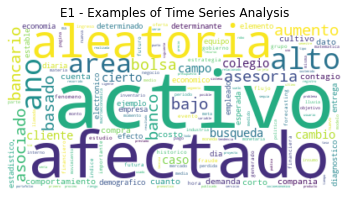

In [517]:
# features - "E1 - Examples of Time Series Analysis"
df1 = vect1.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df1)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E1 - Examples of Time Series Analysis")
plt.axis("off")
plt.show()

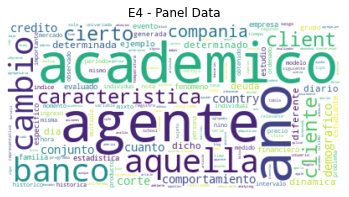

In [518]:
# features - "E4 - Panel Data"
df2 = vect2.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df2)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E4 - Panel Data")
plt.axis("off")
plt.show()

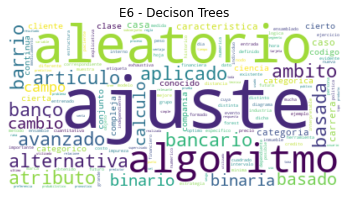

In [519]:
# features - "E6 - Decison Trees"
df3 = vect3.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df3)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E6 - Decison Trees")
plt.axis("off")
plt.show()

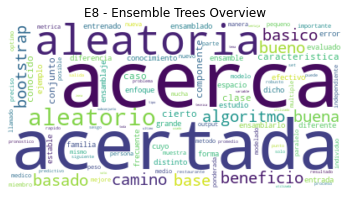

In [520]:
# features - "E8 - Ensemble Trees Overview"
df4 = vect4.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df4)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E8 - Ensemble Trees Overview")
plt.axis("off")
plt.show()

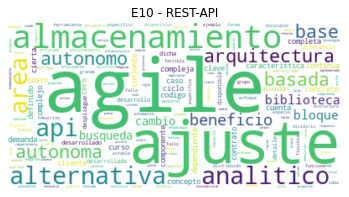

In [521]:
# features - "E10 - REST-API"
df5 = vect5.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df5)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E10 - REST-API")
plt.axis("off")
plt.show()

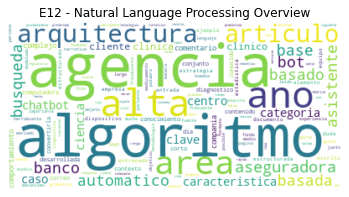

In [522]:
# features - "E12 - Natural Language Processing Overview"
df6 = vect6.get_feature_names()

#Creating the text variable
text = " ".join(title for title in df6)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("E12 - Natural Language Processing Overview")
plt.axis("off")
plt.show()

# Exercise 13.2

Create a classifier to predict the gender of each student



In [523]:
y = df.Genero
df['Genero'].unique()

array(['m', 'f'], dtype=object)

In [524]:
# model
X = (X1_dtm,X2_dtm,X3_dtm,X4_dtm,X5_dtm,X6_dtm)

print('model','accuracy')
for i in range(0,6):
    nb = MultinomialNB()
    print('X'+str(i+1),pd.Series(cross_val_score(nb, X[i], y, cv=10)).mean())

model accuracy
X1 0.35833333333333334
X2 0.7166666666666667
X3 0.6333333333333334
X4 0.6583333333333333
X5 0.7333333333333334
X6 0.4416666666666666


In [525]:
# best model and predict
X = X5_dtm
nb.fit(X,y)
y_pred = nb.predict(X)

print('f',np.count_nonzero(y_pred == 'f'))
print('m',np.count_nonzero(y_pred == 'm'))

f 9
m 29


In [526]:
# real
y.array

print('f',np.count_nonzero(y.array == 'f'))
print('m',np.count_nonzero(y.array == 'm'))

f 10
m 28


# Exercise 13.3
Create a classifier to predict the industry in which each student works

In [527]:
y = df['Sector en el que trabaja']
df['Sector en el que trabaja'].unique()

array(['estudio de mercados', 'no reporta', 'financiero', 'publico',
       'educacion', 'consultoria  de negocios y tecnologia', 'fintech',
       'electrico y de comunicaciones', 'ingenieria de software',
       'operaciones', 'infraestructura de transporte', 'cultura',
       'consumo masivo', 'salud', 'telecomunicaciones'], dtype=object)

In [528]:
# model
X = (X1_dtm,X2_dtm,X3_dtm,X4_dtm,X5_dtm,X6_dtm)

print('model','accuracy')
for i in range(0,6):
    nb = MultinomialNB()
    print('X'+str(i+1),pd.Series(cross_val_score(nb, X[i], y, cv=10)).mean())

model accuracy
X1 0.21666666666666665
X2 0.3416666666666667
X3 0.2833333333333333
X4 0.3
X5 0.3166666666666667
X6 0.3166666666666667


In [529]:
# best model and predict
X = X5_dtm
nb.fit(X,y)
y_pred = nb.predict(X)

print('financiero',np.count_nonzero(y_pred == 'financiero'))
print('no reporta',np.count_nonzero(y_pred == 'no reporta'))
print('fintech',np.count_nonzero(y_pred == 'fintech'))
print('consumo masivo ',np.count_nonzero(y_pred == 'consumo masivo'))
print('electrico y de comunicaciones ',np.count_nonzero(y_pred == 'electrico y de comunicaciones'))
print('educacion',np.count_nonzero(y_pred == 'educacion'))
print('operaciones',np.count_nonzero(y_pred == 'operaciones'))
print('estudio de mercados',np.count_nonzero(y_pred == 'estudio de mercados'))
print('publico',np.count_nonzero(y_pred == 'publico'))
print('telecomunicaciones',np.count_nonzero(y_pred == 'telecomunicaciones'))
print('ingenieria de software',np.count_nonzero(y_pred == 'ingenieria de software'))
print('salud',np.count_nonzero(y_pred == 'salud'))
print('cultura',np.count_nonzero(y_pred == 'cultura'))
print('consultoria  de negocios y tecnologia',np.count_nonzero(y_pred == 'consultoria  de negocios y tecnologia'))
print('infraestructura de transporte',np.count_nonzero(y_pred == 'infraestructura de transporte'))

financiero 14
no reporta 12
fintech 2
consumo masivo  2
electrico y de comunicaciones  0
educacion 1
operaciones 1
estudio de mercados 1
publico 0
telecomunicaciones 1
ingenieria de software 0
salud 1
cultura 1
consultoria  de negocios y tecnologia 1
infraestructura de transporte 1


In [530]:
# real
y.array

print('financiero',np.count_nonzero(y.array == 'financiero'))
print('no reporta',np.count_nonzero(y.array == 'no reporta'))
print('fintech',np.count_nonzero(y.array == 'fintech'))
print('consumo masivo ',np.count_nonzero(y.array == 'consumo masivo'))
print('electrico y de comunicaciones ',np.count_nonzero(y.array == 'electrico y de comunicaciones'))
print('educacion',np.count_nonzero(y.array == 'educacion'))
print('operaciones',np.count_nonzero(y.array == 'operaciones'))
print('estudio de mercados',np.count_nonzero(y.array == 'estudio de mercados'))
print('publico',np.count_nonzero(y.array == 'publico'))
print('telecomunicaciones',np.count_nonzero(y.array == 'telecomunicaciones'))
print('ingenieria de software',np.count_nonzero(y.array == 'ingenieria de software'))
print('salud',np.count_nonzero(y.array == 'salud'))
print('cultura',np.count_nonzero(y.array == 'cultura'))
print('consultoria  de negocios y tecnologia',np.count_nonzero(y.array == 'consultoria  de negocios y tecnologia'))
print('infraestructura de transporte',np.count_nonzero(y.array == 'infraestructura de transporte'))

financiero 12
no reporta 11
fintech 2
consumo masivo  2
electrico y de comunicaciones  1
educacion 1
operaciones 1
estudio de mercados 1
publico 1
telecomunicaciones 1
ingenieria de software 1
salud 1
cultura 1
consultoria  de negocios y tecnologia 1
infraestructura de transporte 1
